In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [2]:
sales = pd.read_csv('../readonly/final_project_data/sales_train.csv.gz')
shops = pd.read_csv('../readonly/final_project_data/shops.csv')
items = pd.read_csv('../readonly/final_project_data/items.csv')
item_cats = pd.read_csv('../readonly/final_project_data/item_categories.csv')
test_data = pd.read_csv('../readonly/final_project_data/test.csv')
sample_submission = pd.read_csv('../readonly/final_project_data/sample_submission.csv')

In [3]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
sales['shop_id'].unique()

array([59, 25, 24, 23, 19, 22, 18, 21, 28, 27, 29, 26,  4,  6,  2,  3,  7,
        0,  1, 16, 15,  8, 10, 14, 13, 12, 53, 31, 30, 32, 35, 56, 54, 47,
       50, 42, 43, 52, 51, 41, 38, 44, 37, 46, 45,  5, 57, 58, 55, 17,  9,
       49, 39, 40, 48, 34, 33, 20, 11, 36], dtype=int64)

# Get a feature matrix
We now need to prepare the features. This part is all implemented for you.

In [5]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [6]:
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [7]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':np.sum})

In [9]:
gb.head()

,shop_id,item_id,date_block_num,item_cnt_day
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0


In [10]:
gb.rename(columns={'item_cnt_day': 'target'}, inplace=True)

In [11]:
gb.head()

,shop_id,item_id,date_block_num,target
0,0,30,1,31.0
1,0,31,1,11.0
2,0,32,0,6.0
3,0,32,1,10.0
4,0,33,0,3.0


In [12]:
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

In [13]:
all_data.head()

,shop_id,item_id,date_block_num,target
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


In [14]:
# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day': np.sum})
gb.rename(columns={'item_cnt_day': 'target_shop'}, inplace=True)
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

In [15]:
# Same as above but with shop-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day': np.sum})
gb.rename(columns={'item_cnt_day': 'target_item'}, inplace=True)
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

In [16]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0
2,59,2554,0,0.0,2017.0,1.0
3,59,2555,0,0.0,2017.0,2.0
4,59,2564,0,0.0,2017.0,5.0


In [17]:
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

In [18]:
# set test_data date_block_num = 34 to build test_data feature
test_data['date_block_num'] =34  

In [19]:
test_data.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


#### After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago

In [20]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    ## Here using "index_cols + cols_to_rename" is very important, copy the whole all_data( bigger and bigger with iation)
    ## will make your pc crazy and is not necessary
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift.rename(columns=foo, inplace=True)
    
    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
    test_data = pd.merge(test_data, train_shift, on=index_cols, how='left').fillna(0)
del train_shift

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [21]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

In [22]:
# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
fit_cols

['target_lag_1',
 'target_item_lag_1',
 'target_shop_lag_1',
 'target_lag_2',
 'target_item_lag_2',
 'target_shop_lag_2',
 'target_lag_3',
 'target_item_lag_3',
 'target_shop_lag_3',
 'target_lag_4',
 'target_item_lag_4',
 'target_shop_lag_4',
 'target_lag_5',
 'target_item_lag_5',
 'target_shop_lag_5',
 'target_lag_12',
 'target_item_lag_12',
 'target_shop_lag_12']

In [23]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12
4488756,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488757,54,10296,12,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488758,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488759,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488760,54,10284,12,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0


In [24]:
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 
to_drop_cols

['target_shop', 'target_item', 'target', 'date_block_num']

In [25]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [26]:
# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
item_category_mapping.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [27]:
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

In [28]:
test_data = pd.merge(test_data, item_category_mapping, how='left', on='item_id')
test_data = downcast_dtypes(test_data)
gc.collect();

In [29]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,12,1.0,8198.0,3.0,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


In [31]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates_train = all_data['date_block_num']
last_block = dates_train.max()
print('Max train `date_block_num` is %d' % last_block)

Max train `date_block_num` is 33


In [32]:
to_drop_cols

['target_shop', 'target_item', 'target', 'date_block_num']

In [33]:
X_train = all_data.drop(to_drop_cols, axis=1)
X_test =  test_data.drop(['ID', 'date_block_num'], axis=1)
X_test = test_data[X_train.columns]  ##  ensure feature order is same
y_train = all_data['target'].values

In [34]:
X_train.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,0.0,4.0,10055.0,0.0,3.0,7978.0,0.0,5.0,6676.0,0.0,3.0,7827.0,0.0,10.0,7792.0,0.0,0.0,0.0,57


# First level models
You need to implement a basic stacking scheme. We have a time component here, so we will use scheme f) from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first.

### Test meta-features
Firts, we will run linear regression on numeric columns and get predictions for the last month.

In [35]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

In [36]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

Finally, concatenate test predictions to get test meta-features.

In [37]:
X_test_level2 = np.c_[pred_lr, pred_lgb] 

In [38]:
X_test_level2.shape

(214200, 2)

### Train meta-features

In [39]:
dates_train_meta = [27, 28, 29, 30, 31, 32, 33]

In [40]:
dates_train_level2 = dates_train[dates_train.isin(dates_train_meta)]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(dates_train_meta)]

In [41]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
for cur_block_num in dates_train_meta:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    #  YOUR CODE GOES HERE
    x_first =  X_train.loc[dates_train <  cur_block_num]
    y_first =  y_train[dates_train <  cur_block_num]
    
    lr.fit(x_first.values, y_first)
    x_test = X_train.loc[dates_train ==  cur_block_num]
    pred_lr = lr.predict(x_test.values)
    
    model = lgb.train(lgb_params, lgb.Dataset(x_first, label=y_first), 100)
    pred_lgb = model.predict(x_test)
    X_train_level2_part = np.c_[pred_lr, pred_lgb]
    X_train_level2[dates_train_level2 == cur_block_num] = X_train_level2_part
print(X_train_level2.mean(axis=0))    

27
28
29
30
31
32
33
[ 0.31298043  0.29446324]


Remember, the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig scatter plot between the two metafeatures. Plot the scatter plot below.

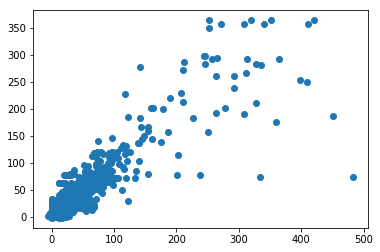

In [42]:
plt.scatter(X_train_level2[:,0], X_train_level2[:,1])
plt.show()

# Ensembling

### Simple convex mix( I give up, time and resource expensive)

```python
alphas_to_try = np.linspace(0, 1, 1001)

# YOUR CODE GOES HERE
mix = (alphas_to_try[None,:] * X_train_level2[:,0][:,None]) + ((1-alphas_to_try[None,:]) * X_train_level2[:,1][:,None])
mse = np.sum(np.power(mix - y_train_level2[:, None], 2), axis=0)
best_alpha = alphas_to_try[mse.argmin()] # YOUR CODE GOES HERE
rmse_train_simple_mix = r2_score(y_train_level2, mix[:, mse.argmin()])# YOUR CODE GOES HERE

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))
```

test_preds_simple_mix = best_alpha * X_test_level2[:,0] + (1 - best_alpha) * X_test_level2[:,1] 

### Stacking

In [46]:
lr_meta = LinearRegression()
lr_meta.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
train_preds = lr_meta.predict(X_train_level2) # YOUR CODE GOES HERE
rmse_train_stacking = np.sqrt(mean_squared_error(y_train_level2, train_preds))# YOUR CODE GOES HERE

test_preds_stacking = lr_meta.predict(X_test_level2)# YOUR CODE GOES HERE

print('Train RMSE for stacking is %f' % rmse_train_stacking)

Train RMSE for stacking is 3.632460


clip prediction (0,20)

In [50]:
test_preds_stacking[test_preds_stacking<0] = 0
test_preds_stacking[test_preds_stacking>20] =20

In [51]:
test_preds_stacking.max()

20.0

In [52]:
test_preds_stacking.min()

0.0

In [63]:
sample_submission.shape

(214200, 2)

In [62]:
submission = pd.DataFrame(np.c_[test_data['ID'].values, test_preds_stacking], columns=['ID', 'item_cnt_month'])

In [64]:
submission.shape

(214200, 2)

In [67]:
submission = downcast_dtypes(submission)

In [72]:
submission['ID'] = submission['ID'].astype(np.int32)

In [74]:
submission.to_csv('sub_2.csv', encoding='utf-8', index=False)